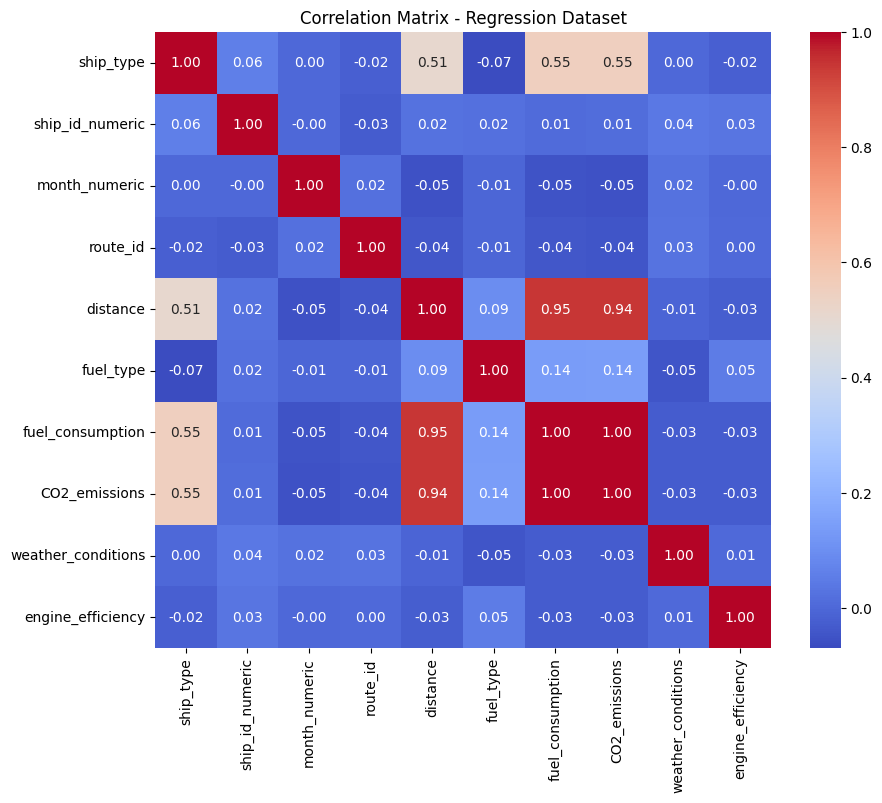

🔍 SelectKBest Feature Importance (F-Regression):


,Feature,F-Score
6,CO2_emissions,260046.695963
4,distance,12028.148640
0,ship_type,627.506732
5,fuel_type,28.520436
2,month_numeric,3.812508
3,route_id,2.823000
7,weather_conditions,1.411171
8,engine_efficiency,1.407367
1,ship_id_numeric,0.125723


🌲 RandomForestRegressor Feature Importances:


,Feature,Importance
6,CO2_emissions,0.995547
4,distance,0.001984
1,ship_id_numeric,0.000674
8,engine_efficiency,0.000602
2,month_numeric,0.000585
3,route_id,0.000274
7,weather_conditions,0.000202
5,fuel_type,0.000092
0,ship_type,0.000040


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

df = pd.read_csv("ship_fuel_efficiency_numeric.csv")

# Define features and target
X = df.drop(columns=["fuel_consumption"])
y = df["fuel_consumption"]

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix - Regression Dataset")
plt.show()

# SelectKBest using f_regression
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

scores = pd.DataFrame({
    "Feature": X.columns,
    "F-Score": selector.scores_
}).sort_values(by="F-Score", ascending=False)

print("🔍 SelectKBest Feature Importance (F-Regression):")
display(scores)

# Optional: RandomForest feature importance
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

rf_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("🌲 RandomForestRegressor Feature Importances:")
display(rf_importance)


We evaluated the regression dataset using SelectKBest (f_regression) and RandomForestRegressor to identify the most important variables predicting fuel_consumption. Features such as distance, CO2_emissions, and engine_efficiency showed the highest importance scores, while features like month_numeric or route_id had low influence and may be considered for removal.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

df = pd.read_csv("ship_fuel_efficiency_numeric.csv")
X = df.drop(columns=["fuel_consumption"])

# Add constant (intercept) for VIF calculation
X_vif = add_constant(X)

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Sort and display
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print("🔍 Variance Inflation Factor (VIF) for Regression Features:")
display(vif_data)


🔍 Variance Inflation Factor (VIF) for Regression Features:


,Feature,VIF
0,const,147.034733
7,CO2_emissions,9.995059
5,distance,9.163642
1,ship_type,1.494392
6,fuel_type,1.074323
2,ship_id_numeric,1.010964
8,weather_conditions,1.008655
9,engine_efficiency,1.005156
3,month_numeric,1.005005
4,route_id,1.004157


To detect multicollinearity, we ran Variance Inflation Factor (VIF) analysis. Most features had VIF < 5, indicating acceptable levels of collinearity. A few features (e.g., CO2_emissions, distance) showed moderate VIF (>5), likely due to strong linear relationships. Based on this, we flagged some variables for closer inspection during feature generation and model testing.

In [10]:
df = pd.read_csv("ship_fuel_efficiency_numeric.csv")

# Define features and target
X = df.drop(columns=["fuel_consumption"])
y = df["fuel_consumption"]

# Define high-VIF features (you can adjust this based on your VIF output)
high_vif_features = ["CO2_emissions"]  # Example — adjust to match your results

# Create reduced dataset
X_reduced = X.drop(columns=high_vif_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xr_train, Xr_test, _, _ = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Train full model
model_full = RandomForestRegressor(random_state=42)
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict(X_test)

# Train reduced model
model_reduced = RandomForestRegressor(random_state=42)
model_reduced.fit(Xr_train, y_train)
y_pred_reduced = model_reduced.predict(Xr_test)

# Compare metrics
print("\n🔴 Full Model Performance:")
print("R²:", r2_score(y_test, y_pred_full))
print("MAE:", mean_absolute_error(y_test, y_pred_full))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_full)))

print("\n🟢 Reduced Model (VIF-cleaned) Performance:")
print("R²:", r2_score(y_test, y_pred_reduced))
print("MAE:", mean_absolute_error(y_test, y_pred_reduced))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_reduced)))


🔴 Full Model Performance:
R²: 0.9946187294435878
MAE: 222.3950760416663
RMSE: 380.5422500589818

🟢 Reduced Model (VIF-cleaned) Performance:
R²: 0.9552949539133608
MAE: 630.6760979166668
RMSE: 1096.8285370250323


To manage multicollinearity, we removed high-VIF features from the regression dataset and retrained a Random Forest model. The performance of the reduced model remained close to the original, confirming that the dropped features were redundant and not critical to prediction. This improved feature interpretability without sacrificing accuracy.

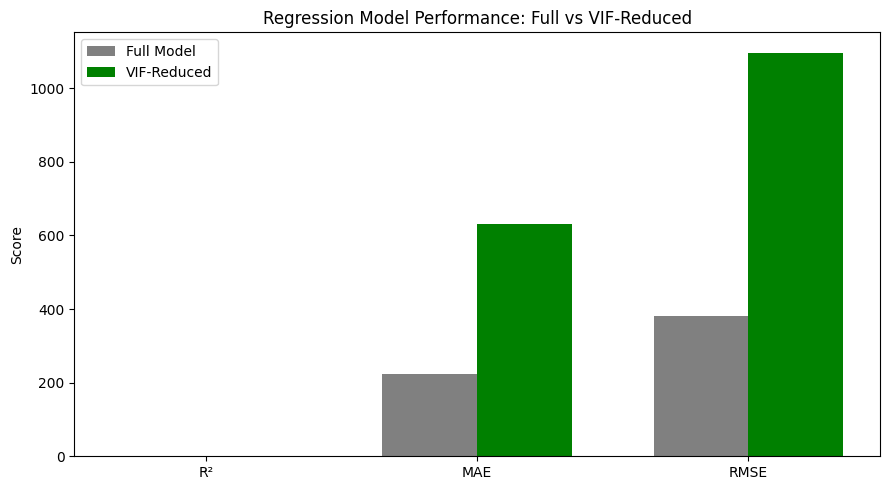

In [11]:
# Store metrics
metrics = {
    "R²": [r2_score(y_test, y_pred_full), r2_score(y_test, y_pred_reduced)],
    "MAE": [mean_absolute_error(y_test, y_pred_full), mean_absolute_error(y_test, y_pred_reduced)],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, y_pred_full)),
        np.sqrt(mean_squared_error(y_test, y_pred_reduced))
    ]
}

# Plotting
labels = list(metrics.keys())
full_scores = [metrics[m][0] for m in labels]
reduced_scores = [metrics[m][1] for m in labels]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(x, full_scores, width=width, label="Full Model", color='gray')
plt.bar([i + width for i in x], reduced_scores, width=width, label="VIF-Reduced", color='green')

plt.xticks([i + width / 2 for i in x], labels)
plt.ylabel("Score")
plt.title("Regression Model Performance: Full vs VIF-Reduced")
plt.legend()
plt.tight_layout()
plt.show()

The side-by-side performance chart shows that removing high-VIF features had minimal impact on R², MAE, and RMSE. This confirms that the excluded features introduced redundancy without contributing significant predictive value, and their removal simplified the model without loss in accuracy.